In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns
import statsmodels

# spacy for lemmatization
import spacy
import gensim
from gensim.utils import simple_preprocess

from sentimentextraction import sent_extraction

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [2]:
df = pd.read_csv('../data/final01.csv')
df = df.dropna()

In [3]:
df['abstract'] = df['abstract'].astype(str)
df['title'] = df['title'].astype(str)

In [4]:
pprint(df.abstract.values[:1])

array(["We present GHUMVEE, a multi-variant execution engine for software intrusion detection. GHUMVEE transparently executes and monitors diversified replicae of processes to thwart attacks relying on a predictable, single data layout. Unlike existing tools, GHUMVEE's interventions in the process' execution are not limited to system call invocations. Because of that design decision, GHUMVEE can handle complex, multi-threaded real-life programs that display non-deterministic behavior as a result of non-deterministic thread scheduling and as a result of pointer-value dependent behavior. This capability is demonstrated on GUI programs from the Gnome and KDE desktop environments. © 2013 Springer-Verlag."],
      dtype=object)


In [5]:
data = df.abstract.values.tolist()

In [6]:
data = [re.sub(r'[\xc2\xa9][^\.]*\.', ' ', abstract) for abstract in data]

In [7]:
%%capture
df = sent_extraction(data, df)

In [8]:
search_term = ""
num_shown=1
a = df[df['journal_name'].str.contains(search_term)]['journal_name']
for i in range(min(num_shown,len(a))):
    print(a.iloc[i])

Lecture Notes in Computer Science (including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics)


In [9]:
to_remove = ["'[0-9]{2}",                # Removing '06 or similar
             '([^0-9a-zA-Z, ]+)',        # Special characters
             '[0-9]{4}',                 # Dates
             '[0-9]+(st|nd|rd|th)',      # Ordinals
             'Proceedings of ',          # Remove cases with 'of' first
             'Proceedings ',             # Remove 'Proceedings' statements
             'the ',                     # 'the' is almost always redundant
             '^ *',                      # Starting and ending spaces
             ' *$']

for i in to_remove:
    df["journal_name"] = df["journal_name"].str.replace(i, '', regex=True)

# Remove repeat whitespace
df["journal_name"] = df["journal_name"].str.replace(' +', ' ', regex=True)

In [10]:
a = df[df['journal_name'].str.contains(search_term)]['journal_name']
for i in range(min(num_shown,len(a))):
    print(a.iloc[i])

Lecture Notes in Computer Science including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


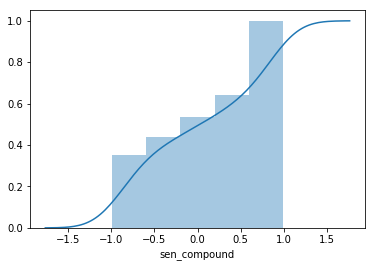

In [11]:
# What do these values mean? Compound is a normalised value [0,1] that isn't directly  
#   calculated from the other three values. -ive means negative, 0 means neautral, 
#   +ive = positive. See https://stackoverflow.com/questions/40325980/how-is-the-vader-compound-polarity-score-calculated-in-python-nltk
sns.distplot(df['sen_compound'], 
             hist_kws={"cumulative":True},
             kde_kws={"cumulative":True})
# plt.figure()
# sns.distplot(df['sen_pos'])
# plt.figure()
# sns.distplot(df['sen_neg'])
# plt.figure()
# sns.distplot(df['sen_neu'])
# plt.figure()


# Create categorical sentiment variable for papers. For diagram only two can be chosen, but
# it may be important to consider neutral as well. -0.6/0.6 splits the datapoints roughly 
# 33/33/33 between the categories for this set, based on the CDF
conditions = [
    (df['sen_compound'] > 0.6),
    (df['sen_compound'] < -0.6),
    (df['sen_compound'] >= -0.6) & (df['sen_compound'] <= 0.6)]
choices = ["positive", "negative", "neutral"]
df['sentiment_category'] = np.select(conditions, choices, default='other')

conditions_b = [
    (df['sen_compound'] > 0),
    (df['sen_compound'] <= 0)]
choices_b = ["positive", "negative"]
df['sentiment_category_binary'] = np.select(conditions_b, choices_b, default='positive')

In [12]:
df = df.reset_index(drop=True)

In [13]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))  # deacc=True removes punctuations

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# iterate over abstracts and lemmatize
abstracts = df.abstract.values.tolist()


abstracts = [re.sub(r'[\xc2\xa9][^\.]*\.', ' ', abstract) for abstract in abstracts]
data_words = list(sent_to_words(data))

# Build the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)


# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)


# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
lemmatized = [' '.join(x) for x in data_lemmatized]
    
print(data_lemmatized[250])


/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


['denial', 'service', 'do', 'attack', 'dangerous', 'consume', 'resource', 'network', 'transport', 'layer', 'firewall', 'consider', 'first', 'line', 'defense', 'network', 'attacker', 'may', 'probe', 'learn', 'firewall', 'policy', 'launch', 'do', 'attack', 'flood', 'firewall', 'traffic', 'target', 'rule', 'bottom', 'policy', 'paper', 'propose', 'countermeasure', 'enable', 'firewall', 'endure', 'attack', 'attempt', 'deny', 'service', 'legitimate', 'client', 'goal', 'work', 'entropy', 'base', 'scheme', 'distinguish', 'legitimate', 'attack', 'traffic', 'legitimate', 'traffic', 'place', 'queue', 'high', 'priority', 'queue', 'hold', 'attack', 'traffic', 'result', 'show', 'propose', 'scheme', 'improve', 'performance', 'firewall', 'do', 'attack']


In [14]:
lemmatized = [' '.join(x) for x in data_lemmatized]
lemmatized_df = pd.DataFrame(lemmatized)
df['abstract_lemmatized'] = lemmatized_df
df.iloc[0:]



paper_id                                              title  \
0    84875925779  GHUMVEE: Efficient, effective, and flexible re...   
1    66749123710  Using received signal strength indicator to de...   
2    84893545692  Defending against eavesdropping attack leverag...   
3    84884127556  Eavesdropping attack in collaborative wireless...   
4    84891356286  Intercept probability analysis of cooperative ...   
5    84959348023  On secrecy performance of antenna-selection-ai...   
6    84893563347  A hybrid technique using multi-objective parti...   
7    80051998644  Binary PSO and random forests algorithm for PR...   
8    66249119391  Bluff-probe based black hole node detection an...   
9    34047255774  Hybrid multi-agent framework for detection of ...   
10   84909968677  Improving intrusion detection system based on ...   
11   84938860401  Improving intrusion detection system based on ...   
12   84879868533  Prevention of ARP spoofing: A probe packet bas...   
13   76749146886  Protecting location privacy against spatial in...   
14   67349147317  Security against probe-response attacks in col...   
15   84886008798  Spoofing cyber attack detection in probe-based...   
16   79960261074  A visualization based simulator for SYN flood ...   
17   70350678961  Danger theory based SYN flood attack detection...   
18   84876035710  DDoS flood attack detection based on fractal p...   
19   44049088453  Detecting voIP floods using the hellinger dist...   
20   47349116678  Detection of HTTP-GET flood attack based on an...   
21   78650122734  Enhancing DDoS flood attack detection via inte...   
22   77955782254                 Flood: Elastic streaming MapReduce   
23   70449092230         More accurate and fast SYN flood detection   
24   52649173690      Protecting databases from query flood attacks   
25   84926395860           RAEED: A solution for hello flood attack   
26   66149161650  Real-time cross-layer design for a large-scale...   
27   84930024739  Use of Tsallis entropy in detection of SYN flo...   
28   84893491079  Visual analytics model for intrusion detection...   
29   84860745723  A differential game approach to mitigating pri...   
..           ...                                                ...   
283  84881582972  Detecting DoS attacks in WSN based on clusteri...   
284  53149142525  Detecting DoS attacks using packet size distri...   
285  84875838637  Detecting flooding based DoS attack in cloud c...   
286  84892640538  Detecting the DOS attacks in AOMDV using AOMDV...   
287  76349115845  Detecting VoIP based DoS attacks at the public...   
288  84856195867  Detection DoS attack on FPGA using fuzzy assoc...   
289  84874411884  Detection of jamming style DoS attack in Wirel...   
290  84861438303  DiCode: DoS-resistant and distributed code dis...   
291  82955168401  Distributed defense of distributed DoS using p...   
292  84867094946  DoS attack-tolerant TESLA-based broadcast auth...   
293  78751649037   DoS attacks exploiting signaling in UMTS and IMS   
294  84885218501                        DoS detection is easier now   
295  47849128203         DoS evading mechanism upon service hopping   
296  84949938425   DOS-resistant authentication with client puzzles   
297  84885603471  Dynamic entropy based DoS attack detection method   
298  84944400381  Dynamic IPv6 activation based defense for IPv6...   
299  84879863997  Early detection of DOS attacks in VANET using ...   
300  46749114084  Early DoS attack detection using smoothened ti...   
301   6344258028  Early statistical anomaly intrusion detection ...   
302  84879874436                         Efficient AS DoS traceback   
303  70449878083  Exception triggered DoS attacks on wireless ne...   
304  84890390578  Exploiting Artificial Immune systems to detect...   
305  84883129120  Fast and secure rendezvous protocols for mitig...   
306  84950135398  FloodGuard: A DoS Attack Prevention Extension ...   
307  51749088327  FOSeL: Filteri

In [15]:
# Scatterplot diagram
import scattertext as st

nlp = spacy.load('en')
corpus = st.CorpusFromPandas(df, 
                             category_col='sentiment_category_binary', 
                             text_col='abstract_lemmatized',
                             nlp=nlp).build()

In [16]:
# The most unique words compared to the corpus
print(list(corpus.get_scaled_f_scores_vs_background().index[:40]))

['vanet', 'wsns', 'eavesdropper', 'alkanet', 'iccdetector', 'togbad', 'rkprofiler', 'eudaemon', 'antimalware', 'rbgs', 'tcpopera', 'lowpan', 'rout', 'malware', 'jamming', 'ciot', 'sinr', 'sobas', 'predistribution', 'thce', 'hifind', 'fosel', 'ghumvee', 'wsn', 'techniqu', 'cusum', 'stackelberg', 'pue', 'frap', 'cliack', 'rehidan', 'tdbs', 'manycore', 'hwsn', 'anfis', 'saclock', 'smrti', 'pillarbox', 'raeed', 'floodguard']


In [17]:
# Get most frequent terms for each type
term_freq_df = corpus.get_term_freq_df()
term_freq_df['negative score'] = corpus.get_scaled_f_scores('negative')
term_freq_df['positive score'] = corpus.get_scaled_f_scores('positive')
# term_freq_df['neutral score'] = corpus.get_scaled_f_scores('neutral')

pprint("Negative:\n"+str(list(term_freq_df.sort_values(by='negative score', ascending=False).index[:10])))
pprint("Positive:\n"+str(list(term_freq_df.sort_values(by='positive score', ascending=False).index[:10])))
# pprint("Neutral:\n"+str(list(term_freq_df.sort_values(by='neutral score', ascending=False).index[:10])))

('Negative:\n'
 "['ddo', 'ipv', 'wormhole', 'ddo attack', 'flood attack', 'service attack', "
 "'router', 'topology', 'real time', 'compromise']")
('Positive:\n'
 "['kernel', 'relay', 'eavesdropper', 'snort_id', 'antenna', 'intercept', "
 "'secrecy', 'image', 'dataset', 'behavioral']")


In [25]:
    cutoff = 0.8
    conditions = [
        (df['sen_compound'] > cutoff),
        (df['sen_compound'] <= (-1 * cutoff))]
    choices = ["positive", "negative"]
    df['sentiment_category'] = np.select(conditions, choices, default='neutral')
    
    df.head()

paper_id                                              title  \
0  84875925779  GHUMVEE: Efficient, effective, and flexible re...   
1  66749123710  Using received signal strength indicator to de...   
2  84893545692  Defending against eavesdropping attack leverag...   
3  84884127556  Eavesdropping attack in collaborative wireless...   
4  84891356286  Intercept probability analysis of cooperative ...   

   num_citations     publication_date  \
0            3.0  2013-04-12 00:00:00   
1           16.0  2009-06-15 00:00:00   
2            4.0  2013-12-01 00:00:00   
3            6.0  2013-09-19 00:00:00   
4           27.0  2013-01-01 00:00:00   

                                        journal_name  journal_impact_factor  \
0  Lecture Notes in Computer Science including su...                  0.655   
1  SPIE The International Society for Optical Eng...                  0.335   
2  International ICST Conference on Communication...                  0.000   
3  IEEE International Conference on Computer Supp...                  0.000   
4    IEEE International Conference on Communications                  0.000   

                                            abstract  sen_compound  sen_neg  \
0  We present GHUMVEE, a multi-variant execution ...       -0.3036    0.032   
1  With the advent of powerful and efficient wire...        0.9516    0.090   
2  Wireless communication is vulnerable to eavesd...        0.5574    0.079   
3  In this paper, we investigate security issues ...        0.5574    0.056   
4  Due to the broadcast nature of wireless medium...        0.8887    0.084   

   sen_neu  sen_pos sentiment_category sentiment_category_binary  \
0    0.949    0.019            neutral                  negative   
1    0.688    0.223           positive                  positive   
2    0.808    0.113            neutral                  positive   
3    0.852    0.092            neutral                  positive   
4    0.777    0.139           positive                  positive   

                                 abstract_lemmatized  
0  present ghumvee multi variant execution engine...  
1  advent powerful efficient wireless sensor node...  
2  wireless communication vulnerable eavesdroppin...  
3  paper investigate security issue collaborative...  
4  due broadcast nature wireless medium wireless ...

In [18]:
html = st.produce_scattertext_explorer(corpus,
          category='positive',
          category_name='Positive Sentiment',
          not_category_name='Negative Sentiment',
          width_in_pixels=1000)
open("Scattertext-Sentiment-Visualization2.html", 'wb').write(html.encode('utf-8'))

796011

In [19]:
feat_builder = st.FeatsFromOnlyEmpath()
empath_corpus = st.CorpusFromParsedDocuments(df,
                                             category_col='sentiment_category_binary',
                                             feats_from_spacy_doc=feat_builder,
                                             parsed_col='abstract_lemmatized').build()
html = st.produce_scattertext_explorer(empath_corpus,
                                       category='positive',
                                       category_name='Positive Sentiment',
                                       not_category_name='Negative Sentiment',
                                       width_in_pixels=1000,
                                       metadata=df['title'],
                                       use_non_text_features=True,
                                       use_full_doc=True,
                                       topic_model_term_lists=feat_builder.get_top_model_term_lists())
open("Scattertext-Sentiment-Visualization2-Empath.html", 'wb').write(html.encode('utf-8'))

1017609

In [1]:
'''
The module for generating the sentiment.
'''
import re

import numpy as np
import pandas as pd
# spacy for lemmatization
import spacy
# gensim
import gensim
import scattertext as st
import nltk

/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [2]:
def lemmatize(df):
    '''
    Performs lemmatization.
    '''

    # NLTK Stop words
    nltk.download('stopwords')
    from nltk.corpus import stopwords

    # Stopword setup
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

    data = df.abstract.values.tolist()
    data = [re.sub(r'[\xc2\xa9][^\.]*\.', ' ', abstract) for abstract in data]

    def sent_to_words(sentences):
        for sentence in sentences:
            yield gensim.utils.simple_preprocess(str(sentence), deacc=True)
    data_words = list(sent_to_words(data))

    # Build the bigram model
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)

    from gensim.utils import simple_preprocess

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent))
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] \
                 for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en', disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams,
                                    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    lemmatized = [' '.join(x) for x in data_lemmatized]
    lemmatized_df = pd.DataFrame(lemmatized)

    df['lemmatized'] = lemmatized_df

    return df

In [3]:
def sent_extraction(data, df, verbose=False):
    '''takes a list of fields and a dataframe, and returns an
    updated dataframe with the sentiment analysis results appended.
    Assumes that the strings in 'data' line up with those in df.'''
    # Currently Using NLTK Vader Sentiment Analyzer:
    #  Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
    #  Sentiment Analysis of Social Media Text. Eighth International Conference on
    #  Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

    nltk.download('vader_lexicon')
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    sid = SentimentIntensityAnalyzer()
    sentiments = []

    # Extract sentiment for each abstract
    for abstract in data:
        ss = sid.polarity_scores(abstract)
        sentiments.append(ss)
        if verbose:
            for k in sorted(ss):
                print('\t {0}: {1}, '.format(k, ss[k]), end='')
            print('\n')

    # Append back to dataframe
    return df.assign(sen_compound=[x['compound'] for x in sentiments],
                     sen_neg=[x['neg'] for x in sentiments],
                     sen_neu=[x['neu'] for x in sentiments],
                     sen_pos=[x['pos'] for x in sentiments])

In [ ]:

filename = '../data/final01.csv'
output_file = "Scattertext-Sentiment-Visualization2.html"
cutoff = 0.2
lemmatized=False
empath=False
'''
Generates a html sentiment graph in output_file, based on the data in filename.
Cutoff is used for determining whether a sentiment is positive or negative.
lemmatized turns on or off lemmatization.
empath turns on or off the use of emptah topics.
'''
df = pd.read_csv(filename)
df = df.dropna()
df = df.reset_index(drop=True)

df['abstract'] = df['abstract'].astype(str)
df['title'] = df['title'].astype(str)
data = df.abstract.values.tolist()
data = [re.sub(r'[\xc2\xa9][^\.]*\.', ' ', abstract) for abstract in data]
df = sent_extraction(data, df)

# Create categorical sentiment variable for papers.
# For diagram only two can be chosen, but it may be important to consider
# neutral as well. -0.6/0.6 splits the datapoints roughly 33/33/33 between
# the categories for this set, based on the CDF
conditions = [
    (df['sen_compound'] > cutoff),
    (df['sen_compound'] <= (-1 * cutoff))]
choices = ["positive", "negative"]
df['sentiment_category'] = np.select(conditions, choices, default='neutral')
df = df.drop(df[df['sentiment_category'] == 'neutral'].index)

print(df)

# Set column for text to be graphed
text_column = 'abstract'
# If required, lemmatize and remove stopwords
if lemmatized:
    df = lemmatize(df)
    text_column = 'lemmatized'

print(df['lemmatized'])

# Generate HTML Scattertext diagram
import en_core_web_sm
nlp = en_core_web_sm.load()

# nlp = spacy.load('en-core-web-sm')

if not empath:
    corpus = st.CorpusFromPandas(df,
                                 category_col='sentiment_category',
                                 text_col=text_column,
                                 nlp=nlp).build()
    html = st.produce_scattertext_explorer(corpus,
                                           category='positive',
                                           category_name='Positive Sentiment',
                                           not_category_name='Negative Sentiment',
                                           width_in_pixels=1000,
                                           metadata=df['title'])

else:
    feat_builder = st.FeatsFromOnlyEmpath()
    empath_corpus = st.CorpusFromParsedDocuments(df,
                                                 category_col='sentiment_category',
                                                 feats_from_spacy_doc=feat_builder,
                                                 parsed_col=text_column).build()
    html = st.produce_scattertext_explorer(empath_corpus,
                                           category='positive',
                                           category_name='Positive Sentiment',
                                           not_category_name='Negative Sentiment',
                                           width_in_pixels=1000,
                                           metadata=df['title'],
                                           use_non_text_features=True,
                                           use_full_doc=True,
                                           topic_model_term_lists=feat_builder\
                                                                  .get_top_model_term_lists())

open(output_file, 'wb').write(html.encode('utf-8'))